In [1]:
import tensorflow as tf
import keras
import scipy.misc
from cleverhans.utils_mnist import data_mnist
from cleverhans.utils_tf import model_eval
import numpy as np
from mnist_cnn import cnn_model
from new_defense_mnist import *
from visualize import *
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="3"

Using TensorFlow backend.


#### Create TF session and set as Keras backend session

In [2]:
keras.layers.core.K.set_learning_phase(0)

sess = tf.Session()
keras.backend.set_session(sess)

#### Get MNIST test data

In [3]:
X_train, Y_train, X_test, Y_test = data_mnist(train_start=0,
                                                  train_end=60000,
                                                  test_start=0,
                                                  test_end=10000)


Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)


In [4]:
# Define input TF placeholder
x = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
y = tf.placeholder(tf.float32, shape=(None, 10))

# Define TF model graph
model, logits = cnn_model(logits=True, input_ph=x)
preds = model(x)
print("Defined TensorFlow model graph.")

Defined TensorFlow model graph.


In [5]:
# Load model
model_path = "/home/vishaal/workspace/obfuscated-gradients/inputtransformations/models/mnist"
ckpt = tf.train.get_checkpoint_state(model_path)
ckpt_path = False if ckpt is None else ckpt.model_checkpoint_path
if ckpt_path:
    saver = tf.train.Saver()
    saver.restore(sess, ckpt_path)
    print("Model loaded from: {}".format(ckpt_path))

INFO:tensorflow:Restoring parameters from /home/vishaal/workspace/obfuscated-gradients/inputtransformations/models/mnist/mnist.ckpt
Model loaded from: /home/vishaal/workspace/obfuscated-gradients/inputtransformations/models/mnist/mnist.ckpt


## Craft adversarial examples for each digit

In [6]:
nb_classes = 10
nb_adv_per_sample = 1
print('Crafting ' + str(nb_classes) + ' adversarial examples: ' + str(nb_adv_per_sample) + ' per class')
print('Target label of ith class is i+1')

# Get the first sample of each class from the test set
idxs = [np.where(np.argmax(Y_test, axis=1) == i)[0][0] for i in range(nb_classes)]

# Create the input array
adv_inputs = np.array(X_test[idxs], dtype=np.float32)

# Create the target labels
one_hot = np.zeros((nb_classes, nb_classes))
one_hot[np.arange(nb_classes), np.arange(nb_classes)] = 1

# Rotate one_hot anti-clockwise for l+1 labeling of targets
zero = np.reshape(one_hot[0], (1, 10))
one_hot_ = np.concatenate((one_hot[1:], zero), axis=0)

# Target labels
adv_ys = np.array(one_hot_, dtype=np.float32).reshape((10, 10))

Crafting 10 adversarial examples: 1 per class
Target label of ith class is i+1


#### Visualize the clean examples

('Predicted labels of clean images', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
('Predicted top-1 confidence of clean images', [0.90521252, 0.88125831, 0.88141775, 0.6121341, 0.8750028, 0.74069035, 0.88542086, 0.89408392, 0.89464343, 0.95346892])


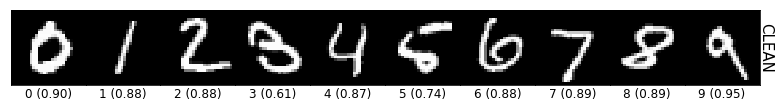

In [7]:
% matplotlib inline
import matplotlib.pyplot as plt

# Get the predicted labels and confidences of the clean images
fd = {x : adv_inputs}
adv_probs = sess.run(preds, feed_dict=fd)
top_1 = list(np.argmax(adv_probs, 1))             # predicted labels of clean samples
confidence = []                                   # predicted top-1 confidence of clean samples
for i in range(nb_classes):
    confidence.append(adv_probs[i][top_1[i]])
    
print("Predicted labels of clean images", top_1)
print("Predicted top-1 confidence of clean images", confidence)

FC = plt.figure(1, (16.0, 1.8))
#gs = gridspec.GridSpec(2, 1, width_ratios=[10, 10])
FC.subplots_adjust(left=0.25)
#AX_perturbations(F)
AX_actual(FC, adv_inputs, top_1, confidence, 'CLEAN')
plt.draw()
#plt.tight_layout()
plt.savefig('clean.png')

#### Define the placeholders and the Loss function

In [8]:
l2_x = tf.placeholder(tf.float32, (None, 28, 28, 1))
l2_orig = tf.placeholder(tf.float32, (None, 28, 28, 1))

# L2 loss - measure of perceptual distance
normalized_l2_loss = tf.nn.l2_loss(l2_orig - l2_x) / tf.nn.l2_loss(l2_orig)

# Only latest version of tf has attribute *_v2*
#xent = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=one_hot(TARGET, 1000))
xent = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=adv_ys)
lam = tf.placeholder(tf.float32, ())

# Total loss
loss = xent + lam * normalized_l2_loss
grad, = tf.gradients(loss, x)

#### Projected Gradient Descent (failed attack)

In [9]:
print('This could take some time...')

# PGD
% matplotlib inline
import matplotlib.pyplot as plt

LAM = 1.0
LR = 0.1

adv_x = np.copy(adv_inputs)
for i in range(50):
    g, l2, p = sess.run([grad, normalized_l2_loss, preds], {x: adv_x, lam: LAM, l2_x: adv_x, l2_orig: adv_inputs})
    print('step %d, l2=%f' % (i, l2))
    # step
    adv_x -= LR * g
    # project
    adv_x = np.clip(adv_x, 0, 1)

This could take some time...
step 0, l2=0.000000
step 1, l2=0.000446
step 2, l2=0.001565
step 3, l2=0.003304
step 4, l2=0.005531
step 5, l2=0.007985
step 6, l2=0.010649
step 7, l2=0.013319
step 8, l2=0.015992
step 9, l2=0.018660
step 10, l2=0.021340
step 11, l2=0.023822
step 12, l2=0.026327
step 13, l2=0.028699
step 14, l2=0.031049
step 15, l2=0.033413
step 16, l2=0.035997
step 17, l2=0.038737
step 18, l2=0.041476
step 19, l2=0.044154
step 20, l2=0.046791
step 21, l2=0.049390
step 22, l2=0.051923
step 23, l2=0.054520
step 24, l2=0.057133
step 25, l2=0.059754
step 26, l2=0.062255
step 27, l2=0.064687
step 28, l2=0.067097
step 29, l2=0.069455
step 30, l2=0.071612
step 31, l2=0.073718
step 32, l2=0.075783
step 33, l2=0.077868
step 34, l2=0.079875
step 35, l2=0.081742
step 36, l2=0.083571
step 37, l2=0.085316
step 38, l2=0.086956
step 39, l2=0.088621
step 40, l2=0.090235
step 41, l2=0.091849
step 42, l2=0.093376
step 43, l2=0.094893
step 44, l2=0.096401
step 45, l2=0.097870
step 46, l2=0.0

In [10]:
# Generate perturbation corresponding to each adversarial image
perturbations = adv_x - adv_inputs

# Get the predicted labels and confidences of the generated adversarial images
fd = {x : adv_x}
adv_probs = sess.run(preds, feed_dict=fd)
top_1 = list(np.argmax(adv_probs, 1))             # predicted labels of AX
confidence = []                                   # predicted top-1 confidence of AX
for i in range(nb_classes):
    confidence.append(adv_probs[i][top_1[i]])
    
print("Predicted labels of AX", top_1)
print("Predicted top-1 confidence of AX", confidence)

eval_params = {'batch_size': nb_classes}
acc = model_eval(sess, x, y, preds, adv_x, adv_ys, args=eval_params)
print('\nSuccess rate of adversarial examples: %0.4f\n' % acc)

('Predicted labels of AX', [1, 2, 3, 4, 5, 6, 7, 8, 9, 0])
('Predicted top-1 confidence of AX', [0.21418558, 0.95578843, 0.85562652, 0.70499557, 0.834665, 0.89473152, 0.29281041, 0.86246943, 0.91992569, 0.84331137])

Success rate of adversarial examples: 1.0000



#### Save the adversarial images

In [11]:
from PIL import Image
for i in range(10):
    X = adv_x[i:i+1][0].reshape(28,28)
    #X_ = perturbations[i:i+1][0].reshape(28,28)
    #X_inp = adv_inputs[i:i+1][0].reshape(28, 28)
    out = "adv_images/mnist/" + '{0:05d}'.format(i) + ".jpg"
    #per = "perturbations/fgsm/" + '{0:05d}'.format(i) + ".png"
    #inp = "adv_images/clean/" + '{0:05d}'.format(i) + ".png"
    scipy.misc.imsave(out, X)
    #scipy.misc.imsave(per, X_)
    #scipy.misc.imsave(inp, X_inp)

/home/vishaal/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  if __name__ == '__main__':


#### Visualize the adversarial images

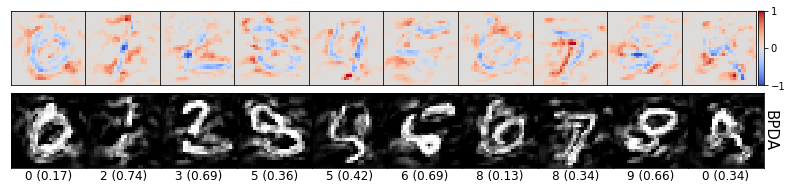

In [21]:
% matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import gridspec
from decimal import *

def AX_perturbations(fig, perturbations):
    """
    A grid of 1x10 images representing the perturbations of the 
    generated AXs - with a single coolwarm colorbar at the right
    """
    grid = AxesGrid(fig, 211,  # similar to subplot(211)
            nrows_ncols=(1, 10),
            axes_pad=0.0,
            share_all=True,
            label_mode="1",
            cbar_location="right",
            cbar_mode="single",
            cbar_size="7%",
            cbar_pad="3%",
            )

    for i in range(nb_classes):
        img = perturbations[i].reshape([28, 28])
        im = grid[i].imshow(img, interpolation="nearest", cmap=cm.coolwarm, vmin=-1., vmax=1.)
        grid[i].tick_params(which='both',bottom='off',left='off',labelbottom='off',labelleft='off')
    import matplotlib as mpl
    norm_ = mpl.colors.Normalize(vmin=-1.,vmax=1.)
    grid.cbar_axes[0].colorbar(im, norm=norm_)
    #grid.cbar_axes[0].set_yticklabels(['-1', '0', '1'])
    grid.cbar_axes[0].set_yticks((-1, 0, 1))

def AX_actual(fig, adv_x, confidence):
    """
    A grid of 1x10 images displaying the actual AXs along with 
    their predicted labels and confidences"""
    grid = AxesGrid(fig, 212,  # similar to subplot(212)
            nrows_ncols=(1, 10),
            axes_pad=0.0,
            share_all=True,
            label_mode="all"
            )
    for i in range(nb_classes):
        img = adv_x[i].reshape([28,28])
        im = grid[i].imshow(img, cmap='gray')
        grid[i].tick_params(which='both',bottom='off',left='off', labelbottom='off', labelleft='off')
        conf = str(Decimal(str(confidence[i])).quantize(Decimal('0.01'), rounding=ROUND_DOWN))
        #xlabel = str(top_1[i]) + " " + "(" + '{0:.2f}'.format(confidence[i]) + ')'
        xlabel = str(top_1[i]) + " " + "(" + conf + ")"
        grid[i].set_xlabel(xlabel, labelpad=2.0, fontsize=12)
    grid[9].yaxis.set_label_position("right")
    grid[9].set_ylabel('BPDA', labelpad=14.0, fontsize=15, rotation=270)

    #grid.axes_llc.set_xticks("")


F = plt.figure(1, (11.0, 2.8))
#gs = gridspec.GridSpec(2, 1, width_ratios=[10, 10])
F.subplots_adjust(left=0.25)
AX_perturbations(F, perturbations)
AX_actual(F, adv_x, confidence)
plt.draw()
plt.tight_layout(h_pad=0.1)
plt.savefig('mnist_adv_bpda.png')

### Average distortion introduced by the attack 

In [13]:
# Compute the average distortion introduced by the algorithm
percent_perturbed = np.mean(np.sum((adv_x - adv_inputs)**2,
                                       axis=(1, 2, 3))**.5)
print('Avg. L_2 norm of perturbations: {0:.4f}'.format(percent_perturbed))

Avg. L_2 norm of perturbations: 2.9762


### Vectorize the adversarial images

In [15]:
adv_vec = defend_vectorize(sess, adv_x)

In [16]:
# Generate perturbation corresponding to each purified adversarial image
perturbations = adv_vec - adv_inputs

# Get the predicted labels and confidences of the generated adversarial images
fd = {x : adv_vec}
adv_probs = sess.run(preds, feed_dict=fd)
top_1 = list(np.argmax(adv_probs, 1))             # predicted labels of purified AX
confidence = []                                   # predicted top-1 confidence of purified AX
for i in range(nb_classes):
    confidence.append(adv_probs[i][top_1[i]])
    
print("Predicted labels of purified AX", top_1)
print("Predicted top-1 confidence of purified AX", confidence)

('Predicted labels of purified AX', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
('Predicted top-1 confidence of purified AX', [0.91436613, 0.88692468, 0.59620869, 0.3959755, 0.36830062, 0.52441376, 0.87610126, 0.89486301, 0.88661653, 0.89804417])


#### Visualize the purified adversarial images

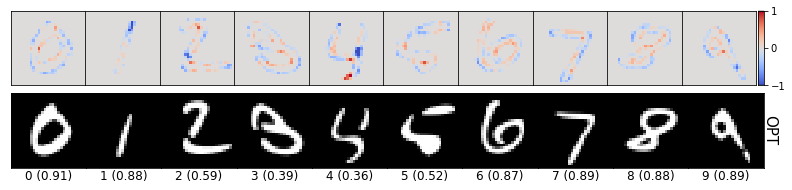

In [16]:
FP = plt.figure(1, (11.0, 2.8))
#gs = gridspec.GridSpec(2, 1, width_ratios=[10, 10])
FP.subplots_adjust(left=0.25)
AX_perturbations(FP, perturbations)
AX_actual(FP, adv_vec, confidence)
plt.draw()
plt.tight_layout(h_pad=0.1)
plt.savefig('mnist_adv_pur.png')

### Use Backward Pass Differentiable Approximation (BPDA) for the attack

In [17]:
print('This could take a long time........')

# PGD

LAM = 1.0
LR = 0.1

adv_x = np.copy(adv_inputs)
for i in range(50):
    adv_def = defend_vectorize(sess, adv_x)
    g, l2, p = sess.run([grad, normalized_l2_loss, preds], {x: adv_def, lam: LAM, l2_x: adv_x, l2_orig: adv_inputs})
    print('step %d, l2=%f' % (i, l2))
    # step
    adv_x -= LR * g
    # project
    adv_x = np.clip(adv_x, 0, 1)

This could take a long time........
step 0, l2=0.000000
step 1, l2=0.000456
step 2, l2=0.001785
step 3, l2=0.003967
step 4, l2=0.007026
step 5, l2=0.010892
step 6, l2=0.015513
step 7, l2=0.020986
step 8, l2=0.026917
step 9, l2=0.033539
step 10, l2=0.040693
step 11, l2=0.048429
step 12, l2=0.056742
step 13, l2=0.064581
step 14, l2=0.072650
step 15, l2=0.081091
step 16, l2=0.088804
step 17, l2=0.096602
step 18, l2=0.104374
step 19, l2=0.112855
step 20, l2=0.122518
step 21, l2=0.131111
step 22, l2=0.139681
step 23, l2=0.148617
step 24, l2=0.158412
step 25, l2=0.167609
step 26, l2=0.176499
step 27, l2=0.184492
step 28, l2=0.193209
step 29, l2=0.200295
step 30, l2=0.207400
step 31, l2=0.214347
step 32, l2=0.220722
step 33, l2=0.227434
step 34, l2=0.233891
step 35, l2=0.240273
step 36, l2=0.246655
step 37, l2=0.252837
step 38, l2=0.258813
step 39, l2=0.264583
step 40, l2=0.270620
step 41, l2=0.275842
step 42, l2=0.280902
step 43, l2=0.284836
step 44, l2=0.289630
step 45, l2=0.294361
step 46,

#### Visualize the adversarial images

('Predicted labels of BPDA AX', [0, 2, 3, 5, 5, 6, 8, 8, 9, 0])
('Predicted top-1 confidence of BPDA AX', [0.17410825, 0.7466296, 0.69152158, 0.36375561, 0.42649496, 0.69479233, 0.13422583, 0.34502977, 0.66615212, 0.34043133])

Success rate of adversarial examples: 0.7000



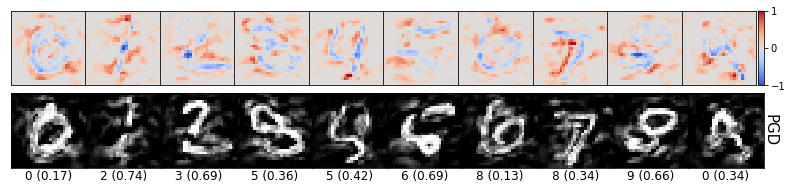

In [19]:
import cPickle as pickle
with open('white_vec.p', 'wb') as f:
    pickle.dump(adv_x, f)

# Generate perturbation corresponding to each purified adversarial image
perturbations = adv_x - adv_inputs

# Get the predicted labels and confidences of the generated adversarial images
fd = {x : adv_x}
adv_probs = sess.run(preds, feed_dict=fd)
top_1 = list(np.argmax(adv_probs, 1))             # predicted labels of purified AX
confidence = []                                   # predicted top-1 confidence of purified AX
for i in range(nb_classes):
    confidence.append(adv_probs[i][top_1[i]])
    
print("Predicted labels of BPDA AX", top_1)
print("Predicted top-1 confidence of BPDA AX", confidence)

eval_params = {'batch_size': nb_classes}
acc = model_eval(sess, x, y, preds, adv_x, adv_ys, args=eval_params)
print('\nSuccess rate of adversarial examples: %0.4f\n' % acc)

FP_x = plt.figure(1, (11.0, 2.8))
#gs = gridspec.GridSpec(2, 1, width_ratios=[10, 10])
FP_x.subplots_adjust(left=0.25)
AX_perturbations(FP_x, perturbations)
AX_actual(FP_x, adv_x, confidence)
plt.draw()
plt.tight_layout(h_pad=0.1)
plt.savefig('mnist_adv_bpda.png')

### Average distortion introduced by the BPDA attack

In [21]:
# Compute the average distortion introduced by the algorithm
percent_perturbed = np.mean(np.sum((adv_x - adv_inputs)**2,
                                       axis=(1, 2, 3))**.5)
print('Avg. L_2 norm of perturbations: {0:.4f}'.format(percent_perturbed))

Avg. L_2 norm of perturbations: 5.2875


#### Vectorize the adversarial images generated using BPDA technique

In [22]:
adv_pur = defend_vectorize(sess, adv_x)

In [23]:
# Generate perturbation corresponding to each purified adversarial image
perturbations = adv_pur - adv_inputs

# Get the predicted labels and confidences of the generated adversarial images
fd = {x : adv_pur}
adv_probs = sess.run(preds, feed_dict=fd)
top_1 = list(np.argmax(adv_probs, 1))             # predicted labels of purified AX
confidence = []                                   # predicted top-1 confidence of purified AX
for i in range(nb_classes):
    confidence.append(adv_probs[i][top_1[i]])
    
print("Predicted labels of purified AX", top_1)
print("Predicted top-1 confidence of purified AX", confidence)

('Predicted labels of purified AX', [2, 2, 3, 5, 5, 6, 6, 8, 9, 0])
('Predicted top-1 confidence of purified AX', [0.41611555, 0.89219707, 0.62621957, 0.30666327, 0.76950347, 0.74944454, 0.53224093, 0.6775828, 0.679658, 0.30587113])


#### Visualize the purified adversarial images (generated using BPDA technique)

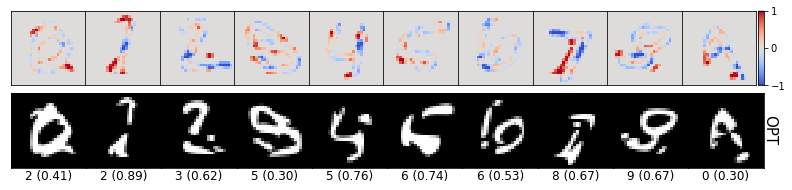

In [24]:
FP_ = plt.figure(1, (11.0, 2.8))
#gs = gridspec.GridSpec(2, 1, width_ratios=[10, 10])
FP_.subplots_adjust(left=0.25)
AX_perturbations(FP_, perturbations)
AX_actual(FP_, adv_pur, confidence)
plt.draw()
plt.tight_layout(h_pad=0.1)
plt.savefig('mnist_adv_pur_bpda.png')